### VaMSL: Approximate inference of $p(G, \Theta, C,  \pi | D)$ for mixtures of (non)linear Gaussian Bayes nets

VaMSL carries out approximate inference over mixtures of Bayesian networks (BN) using coordinate ascent variational inference (CAVI). We instantiate the CAVI update over BNs with the Differentiable Bayesian Structure Learning (DiBS) ([Lorch et al., 2021](https://proceedings.neurips.cc/paper/2021/hash/ca6ab34959489659f8c3776aaf1f8efd-Abstract.html)) framework and it's Stein Variational gradient descent (SVGD) ([Liu and Wang, 2016](https://proceedings.neurips.cc/paper/2016/hash/b3ba8f1bee1238a2f37603d90b58898d-Abstract.html)) implementation.

DiBS leverages a generative model for graphs $p(G | Z)$ conditional on the continuous latent variable $Z$ to enable the use of gradient optimization methods in the (otherwise discrete) graph search accross BNs. Their SVGD implementation enables Bayesian structure learning by yielding a posterior in the BN space $p(G, \Theta | D)$.

In [1]:
%pip install ../.
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as random

print(f"JAX backend: {jax.default_backend()}")
key=random.PRNGKey(123)

Processing /notebooks/VaMSL/VaMSL_proj
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 46.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 51.4 MB/s eta 0:00:0000:010:01
  Created wheel for vamsl-lib: filename=vamsl_lib-1.0-py3-none-any.whl size=54745 sha256=6ed1a817a01de690b4b7b777aaea0f4cc1cc2d94f352a36b4977382d5608fcaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-y77rbd9q/wheels/c3/c1/d4/3d27c46fa93054064e8c77482810837b196d36b38802b832ca
Successfully built vamsl-lib
  Attempting uninstall: jupyterlab-server
    Found existing installation: jupyterlab_server 2.25.2
    Uninstalling jupyterlab_server-2.25.2:
      Successfully uninstalled jupyterlab_server-2.25.2
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.0.9
    Uninstalling jupyterlab-4.0.9:
      Successfully uninstalled

I0000 00:00:1743151265.493671     291 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


JAX backend: cpu


### Define the mixture model.

First we define the mixture of the observations as well as the component BNs in the mixture model. 

The elements of `mixing rate` defines the proportion of the total number of observations that are generated from each component. The entries should sum up to 1. The number of components `n_components` in the mixture model is taken to be the number indicated by the mixing rates, but can be set to a different value if so desired.

Each Gaussain BN has `n_vars` variables and has either a linear or nonlinear mean function depending on `struct_eq_type`. The nonlinear functions are modelled using shallow NNs. The random graph prior is either set to `er` (Erdos-Renyi) or `sf` (scale-free) graphs. 

In [2]:
# Set random seed
key = random.PRNGKey((seed:=124))

# Data settings
n_observations = 200 # total number of observations to generate
ho_frac = 0.5 # fraction of observations held-out (for predicitve perfomance assessment)
mixing_rate = jnp.array([0.5,0.5]) # mixing rate of observations (also defines number of DGPs)
#mixing_rate = 1/(K:=5) * jnp.ones(K) # uniform mixing rates for K components

# BN settings
n_vars = 20 # number of variables in each component BN
struct_eq_type = 'linear' # BN function class: 'linear' or 'nonlinear'
graph_type = 'sf' # Random graph structure: 'sf' (scale-free) or 'er' (Erdos-Renyi)

# Derived variables
n_components = mixing_rate.shape[0]
linear = True if struct_eq_type == 'linear' else False
n_obs = int(n_observations * (1-ho_frac))

### Generate ground truth BNs and synthetic data.

We generate synthetic data from ground truth BNs as specified above. `x_ind` is an observation array with {n_observations, n_vars+1}, where the last column consits of ground truth indicators for the corresponding ground truth BN. The varaibles `lik`, `component_lik`, and `graph_model` define likelihood models and the grpah prior model.

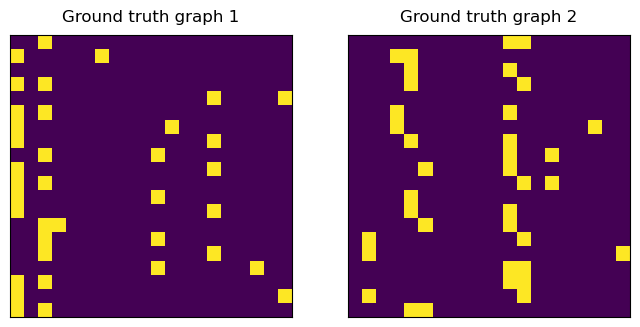

Observations shape:
x: (100, 20)
Indicators and counts:
(Array([0., 1.], dtype=float32), Array([50, 50], dtype=int32))
Node distributions for component  1 :


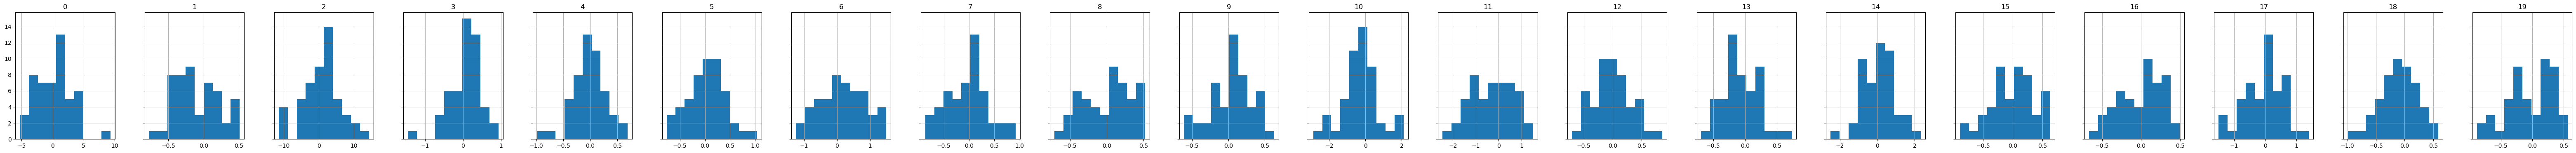

Node distributions for component  2 :


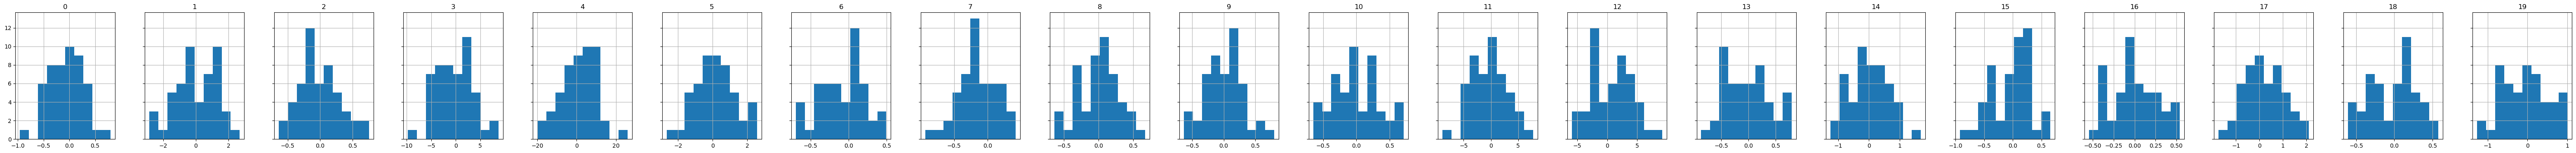

In [23]:
from vamsl.target import make_mixture_model
from vamsl.utils import visualize_ground_truth, visualize_ground_truths

key = random.PRNGKey((seed:=523))
key, subk = random.split(key)
# Generate data (with indicators for component assignment), ground truth BNs, likelihood models, and random graph model
x_ind, ground_truth_graphs, ground_truth_thetas, lik, component_lik, graph_model = make_mixture_model(key=subk,
                                                                                                      mixing_rate=mixing_rate,
                                                                                                      n_vars=n_vars,
                                                                                                      n_observations=n_observations,
                                                                                                      graph_type=graph_type,
                                                                                                      struct_eq_type=struct_eq_type,
                                                                                                      edges_per_node=2,
                                                                                                      obs_noise=0.1)
visualize_ground_truths(ground_truth_graphs)
#print(ground_truth_graphs)
# Remove indicator vector from data
x = x_ind[:n_obs,:n_vars] # [n_observations, n_vars]
indicator = x_ind[:n_obs,n_vars]
x_ho = x_ind[n_obs:,:n_vars] # [n_observations, n_vars]
indicator_ho = x_ind[n_obs:,n_vars]
print('Observations shape:')
print('x: ' + str(x.shape))
print('Indicators and counts:')
print(jnp.unique(indicator, return_counts=True))
for i in range(n_components):
    print('Node distributions for component ', i+1, ':')
    pd.DataFrame(x[indicator==i, :]).hist(sharey=True,figsize=(4*n_vars,4),layout=(1,n_vars))
    plt.show()

In [24]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

if  n_observations > 0:
    n_components = n_components
    random_state = seed

    labels = BayesianGaussianMixture(n_components=n_components, random_state=random_state, init_params='random_from_data', verbose=1).fit_predict(x)
    VGMM_assignments = confusion_matrix(indicator, labels)[:,linear_sum_assignment(confusion_matrix(indicator, labels), maximize=True)[1]]
    print("\nVGMM MAP clustering:\n", VGMM_assignments, '\n')
    print('Percentage missclassified: ', 100*jnp.sum(VGMM_assignments[~jnp.eye(n_components, dtype=bool)])/n_observations, '%') # mask diagonal with logical not of identity matrix

Initialization 0
  Iteration 10
Initialization converged: True

VGMM MAP clustering:
 [[47  3]
 [17 33]] 

Percentage missclassified:  10.0 %


### Create VaMSL.

We create the VaMSL model and intilitialize it with `n_particles` randomly sampled particles latent $Z$ and $\Theta $ particles as well as uniform distributions over responsibilities and weights. If one wants to specify specific prior responsibilities and weights, they can be fed to `initialize_posteriors` as named variables `init_q_c` and `alphas`, of shapes `(n_observations, n_components)` and `(n_components,)` respectively. 

Variational distribution (Posterior) shapes:
q_z:     (2, 6, 20, 20, 2)
q_theta: (2, 6, 20, 20)
log_q_c: (100, 2)
q_pi:    (2,)


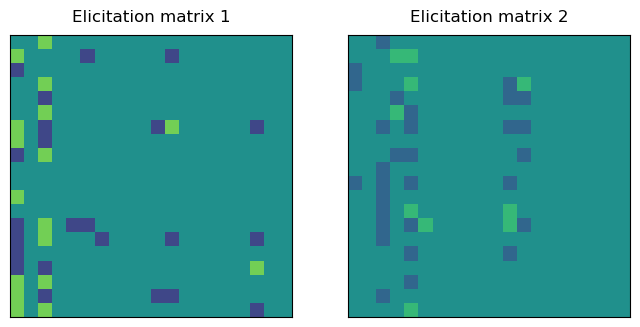

In [25]:
from vamsl.inference import VaMSL

# Create VaMSL and initialize posteriors (remove indicator vecor from dataset)
vamsl = VaMSL(x=x, graph_model=graph_model, mixture_likelihood_model=lik, 
              component_likelihood_model=component_lik, 
              n_mixture_grad_mc_samples=10,
              n_elicitation_grad_mc_samples=1000,
              lamda=50)#n_vars**5)
key, subk = random.split(key)
vamsl.initialize_posteriors(key=subk, n_components=2, n_particles=6, linear=linear)#,init_q_c=jax.nn.one_hot(indicator,n_components))

print('Variational distribution (Posterior) shapes:')
posts = vamsl.get_posteriors()
print('q_z:     ' + str(posts[0].shape)) # [n_components, n_particls, d, l, 2]
print('q_theta: ' + str(posts[1].shape)) if linear else print('q_theta: ' + str(len(posts[1]))) # leading dim of n_components
print('log_q_c: ' + str(posts[2].shape)) # [n_observations, n_components]
print('q_pi:    ' + str(posts[3].shape)) # [n_components,]

# Specify prior elicitation matrix
#vamsl.set_E(0.5*jnp.ones_like(ground_truth_graphs)) # set default (unconstrained)
#vamsl.set_E(jnp.where(ground_truth_graphs, 0.7, 0.3)) # supply correct soft constraints 
#vamsl.set_E(ground_truth_graphs) # supply correct hard constraints
vamsl.set_E(E)
visualize_ground_truths(vamsl.get_E(), graph_label='Elicitation matrix')

In [ ]:
from sklearn.metrics import confusion_matrix

# CAVI and SVGD vars
n_cavi_updates, steps, callback_every = 5, 100, 100

# CAVI-loop
for cavi_update in range(n_cavi_updates):
    key, subk = random.split(key)
    # Optimize q(Z, \Theta)
    vamsl.update_particle_posteriors(key=subk, steps=steps, callback_every=callback_every,
                                     callback=vamsl.visualize_callback(), linear=linear)

    # Update to optimal q(c) and q(\pi)
    vamsl.update_responsibilities_and_weights()
    print(f'CAVI update number {cavi_update+1}/{n_cavi_updates}')
    
    # Print current clustering performance
    order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=indicator)
    y_pred = [order[k] for k in jnp.argmax(vamsl.get_posteriors()[2], axis=1)]
    print('MAP clustering: \n', confusion_matrix(indicator, y_pred))
    
# Final CAVI update with more SVGD steps to ensure annealing unto acyclic graphs
for long_CAVI in range(0):
    key, subk = random.split(key)
    vamsl.update_particle_posteriors(key=subk, steps=2000, callback_every=200, callback=vamsl.visualize_callback(), linear=linear)
    vamsl.update_responsibilities_and_weights()
    
    # Print current clustering performance
    order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=indicator)
    y_pred = [order[k] for k in jnp.argmax(vamsl.get_posteriors()[2], axis=1)]
    print('MAP clustering: \n', confusion_matrix(indicator, y_pred))

### Get order of components with respect to ground truths

We identify an ordering of the components with respect to the ground truth BNs by identifying which perumutation of indeces results in the highest classification accuracy.

In [21]:
# Compute optimal ordering with respect to MAP classification accuracy
order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=indicator)
print('Optimal order:')
print(order)

Optimal order:
[0 1]


### Evaluate classification performance

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
#tests
print('Sums of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2]), axis=0))
print('Average entropy of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2])*vamsl.get_posteriors()[2])/vamsl.get_posteriors()[2].shape[0])
y_true = indicator
y_pred = [order[k] for k in jnp.argmax(vamsl.get_posteriors()[2], axis=1)]
if n_components==2:
    print('Classification report:')
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['Component 1', 'Component 2']))
print('Ordered confusion matrix:\n', (cm:=confusion_matrix(y_true, y_pred)))
print('Percentage missclassified: ', 100*jnp.sum(cm[~jnp.eye(n_components, dtype=bool)])/n_obs, '%') # mask diagonal with logical not of identity matrix

Sums of responsibilities:
[59.619392 40.380608]
Average entropy of responsibilities:
-0.019998966
Classification report:
              precision    recall  f1-score   support

 Component 1       0.57      0.68      0.62        50
 Component 2       0.60      0.48      0.53        50

    accuracy                           0.58       100
   macro avg       0.58      0.58      0.58       100
weighted avg       0.58      0.58      0.58       100

Ordered confusion matrix:
 [[34 16]
 [26 24]]
Percentage missclassified:  42.0 %


### Evaluate structure learning performance

In [12]:
from vamsl.metrics import expected_shd, threshold_metrics

# Loop over components and calculate metrics
for k, dist in zip(range(n_components), vamsl.get_component_dists()):
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=ground_truth_graphs[order[k]])       
    auroc = threshold_metrics(dist=dist, g=ground_truth_graphs[order[k]])['roc_auc']
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}')

 Component    1 |  E-SHD: 36.3    AUROC:  0.62
 Component    2 |  E-SHD: 43.0    AUROC:  0.59


### Evaluate predicitive performance on held-out observations

We use the MAP predicted assignments of held-out observations to each component.  

In [13]:
from vamsl.metrics import MAP_assigned_neg_ave_log_lik

MAP_assigned_neg_ave_log_lik(x=x_ho,
                             MAP_assignments=jnp.argmax(vamsl.compute_log_responsibilities(x=x_ho), axis=1), 
                             dists=vamsl.get_component_dists(), 
                             eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ)

Array(10417.395, dtype=float32)

In [14]:
from vamsl.metrics import MAP_assigned_lppd

MAP_assigned_lppd(x=x_ho,
                  dists=vamsl.get_component_dists(),
                  MAP_assignments=jnp.argmax(vamsl.compute_log_responsibilities(x=x_ho), axis=1),
                  eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ)

Array(-12704.856, dtype=float32)

In [15]:
from vamsl.metrics import mixture_lppd

key, subk = random.split(key)
mixture_lppd(key=subk,
             q_pi=vamsl.get_posteriors()[3],
             x=x_ho,
             dists=vamsl.get_component_dists(),
             eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ)

Array(-11945.939, dtype=float32)

### Elicitation

Incoporate elicited hard and soft edge constraints into VaMSL. Either provide an elicitation matrix, construct one by answering queries, or let a oracle simulate the process of querying an expert.

In [16]:
import numpy as np
from vamsl.elicitation.simulators import bernoulli_simulator, beta_simulator
from vamsl.elicitation import edgeElicitation, graphOracle

# Eliciation parameters
n_queries = 40
random_queries = False
expert_reliability = 1
stochastic = False

# User simulator and utility function
#simulator, expected_utility, soft = bernoulli_simulator(), 'Rao-Blackwellized EIG', False # for hard constraints
simulator, expected_utility, soft = beta_simulator(), 'NMC EIG', True # for soft constraints

# Create query selector and oracle for simulating expert elicitation
elicitor = edgeElicitation(simulator=bernoulli_simulator(), expected_utility='Rao-Blackwellized EIG')
oracle = graphOracle(ground_truth_graphs[order])


E = vamsl.get_E()
# Initialize list of all possible experiments [n_components, n_vars**2, 2]
experiment_lists = np.array([[(i, j) for i in range(n_vars) for j in range(n_vars) if not i==j] for k in range(n_components)])

Querying oracle...


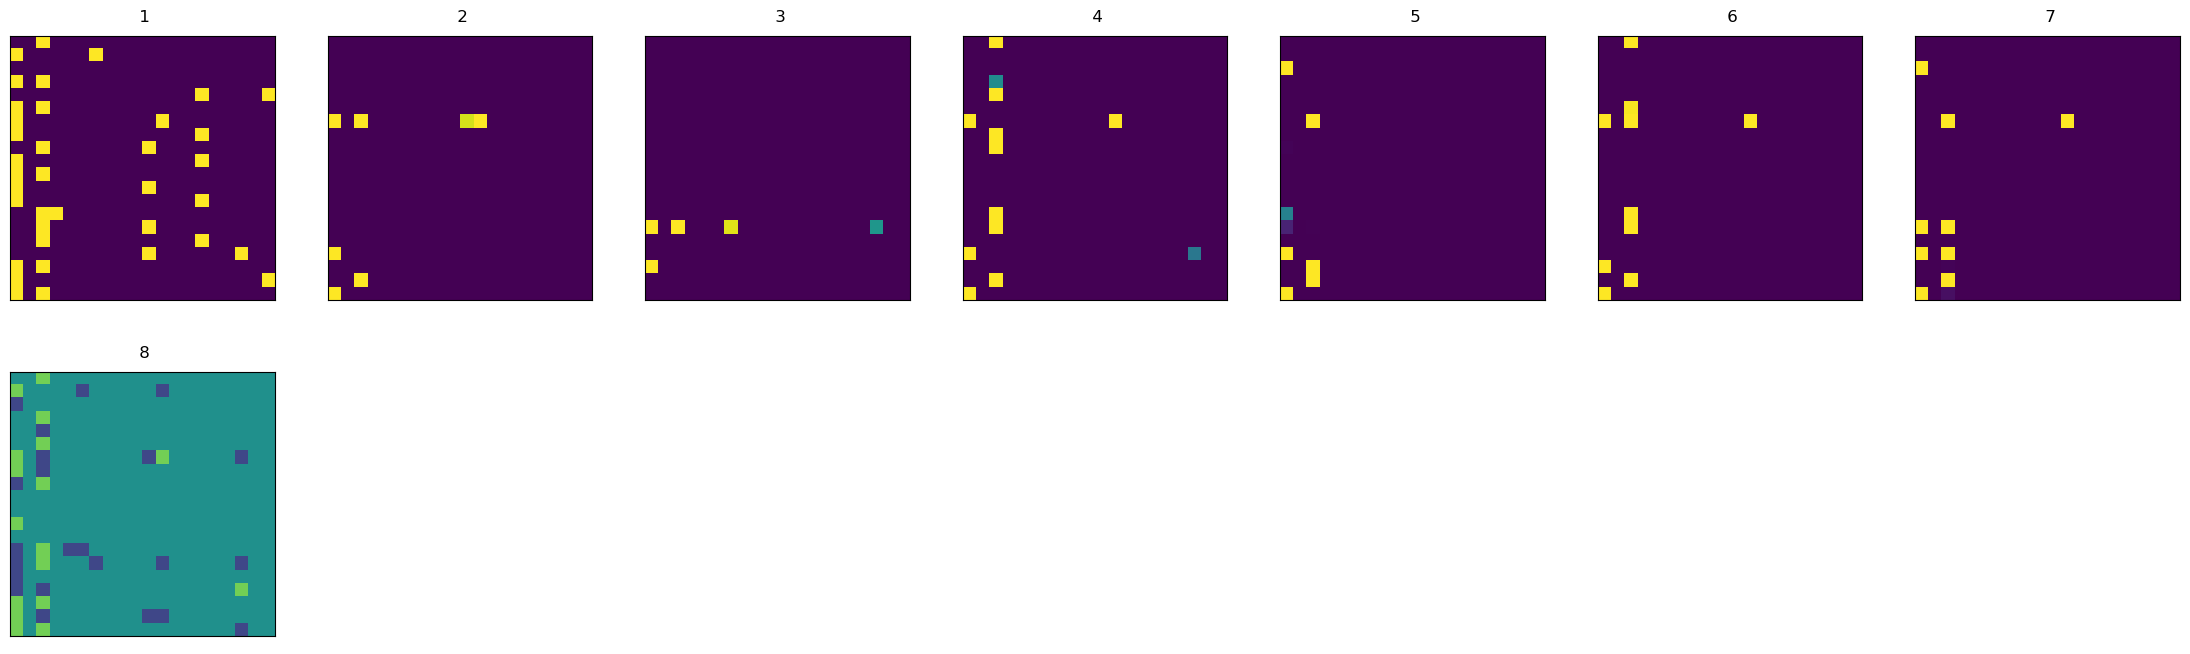

Querying oracle...


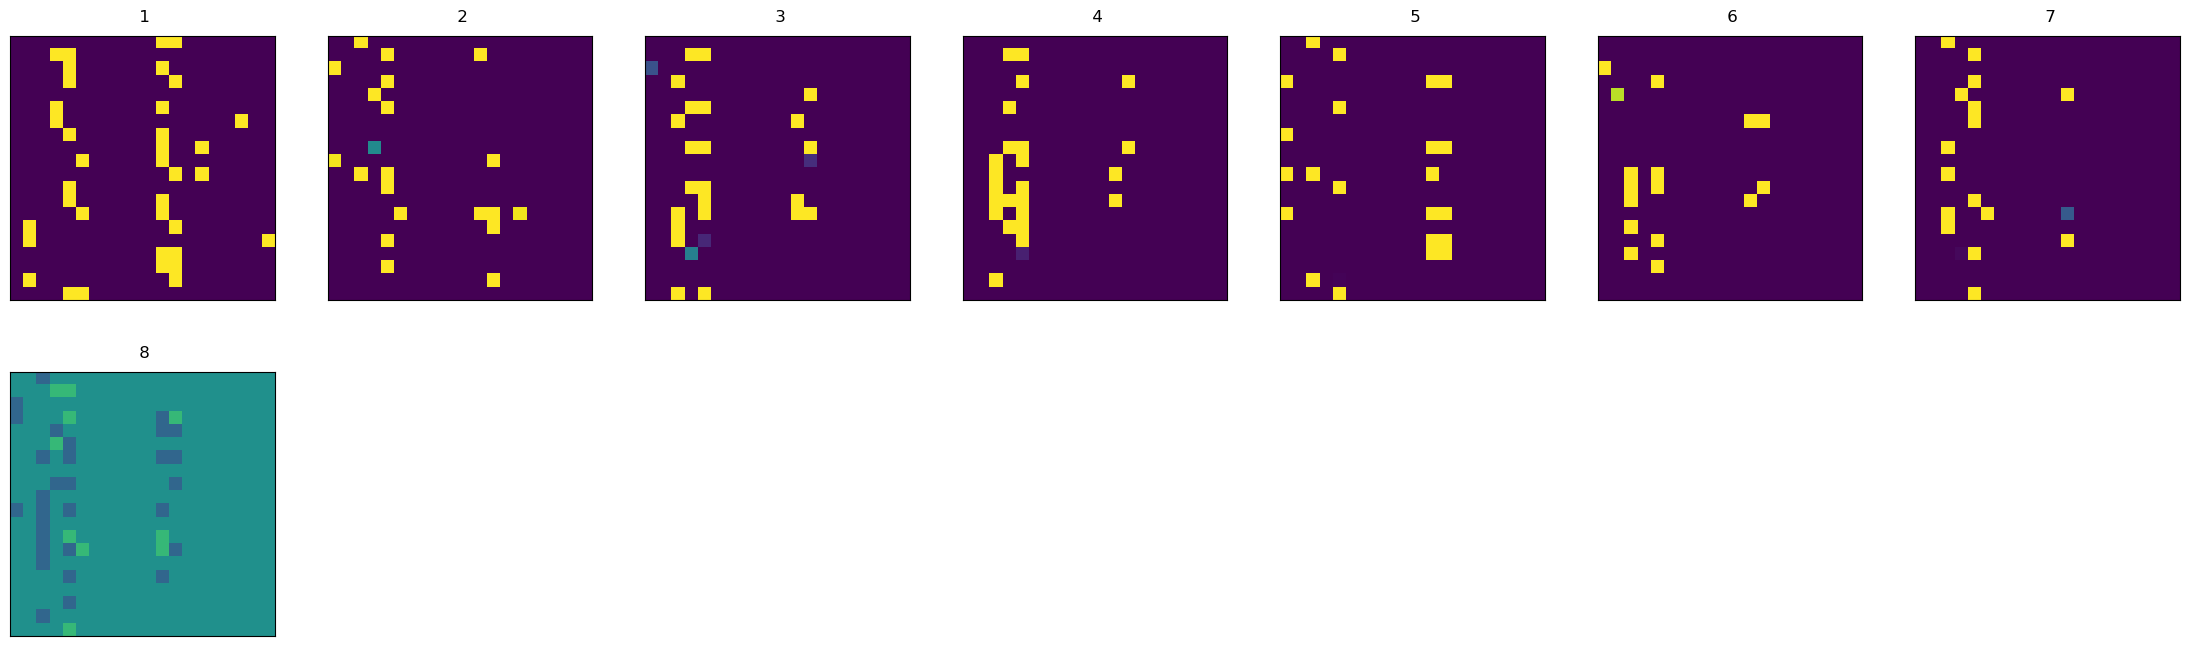

In [17]:
# Elicitation
indices_list = [] # list of edges queries to remove from experiment list
for component in range(n_components): # TODO: Make function
    print('Querying oracle...')
    # Get component parameters which correspond to particle-wise edge probabilities
    q_z_k, E_k = vamsl.get_posteriors()[0][component], vamsl.get_E()[component]
    parameter_samples = jax.vmap(vamsl.edge_probs, (0, None, None))(q_z_k, 1000, E_k)
    
    # Get optimal queries
    experiment_list = experiment_lists[component]
    exps, EIGs, indices = elicitor.optimal_queries(parameter_samples=parameter_samples, 
                                                   experiment_list=experiment_list,
                                                   n_queries=n_queries)
    if random_queries:
        # overwrite BED queries with random
        indices = np.random.choice(range(experiment_list.shape[0]), n_queries, replace=False)
        exps = experiment_list[indices]
    
    # Update elicitation matrix
    key, subk = random.split(key)
    E = oracle.update_elicitation_matrix(E=E, component=component, queries=exps,
                                         stochastic=stochastic, key=subk, 
                                         reliability=expert_reliability,soft=soft)
    indices_list.append(indices)
    
    visualize_ground_truths(mats=jnp.array([ground_truth_graphs[order][component],*[s for s in parameter_samples], E[component]]), graph_label='')

# Remove experiments that were queried from experiment list
experiment_lists = np.array([np.delete(exp_list, exp_is, axis=0) for exp_list, exp_is in zip(experiment_lists, indices_list)])

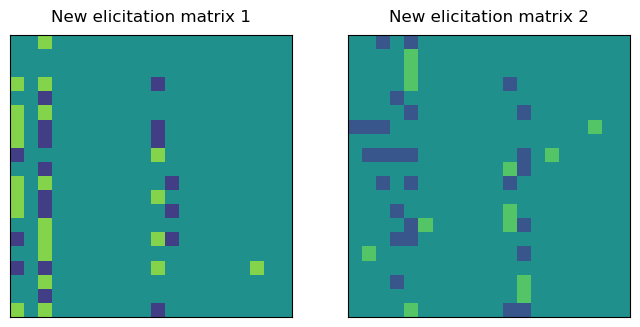

In [33]:
# Update the VaMSL elicitation matrix 
visualize_ground_truths(mats=E, graph_label='New elicitation matrix')
#vamsl.set_E(E)

### Save model and data

In [ ]:
import pickle
#filename = '5_d_14_p_100_s_30_e_2000_s.p'
pickle.dump(vamsl.get_posteriors(), open(filename, 'wb'))

In [ ]:
import pickle
posts = pickle.load(open('20_d_14_p_200_s_20_e_2000_s.p', 'rb'))